In this assignment we implement CycleGAN using Keras with the intention to transform Day time to night time images for Autonomous Drive like in:
https://github.com/simontomaskarlsson/CycleGAN-Keras

This work is an adaptation of the blog in: https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

# Task 0: Install libraries and load data

In [1]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 8.9MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/FourthBrain/Week 9/live-assignment/training/')
!ls

day  discriminator_model_plot.png  generator_model_plot.png  night


## **Task 1 [Instructor Led]:  Design functions for Generator-Discriminator pairs**: 


Step 1: Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

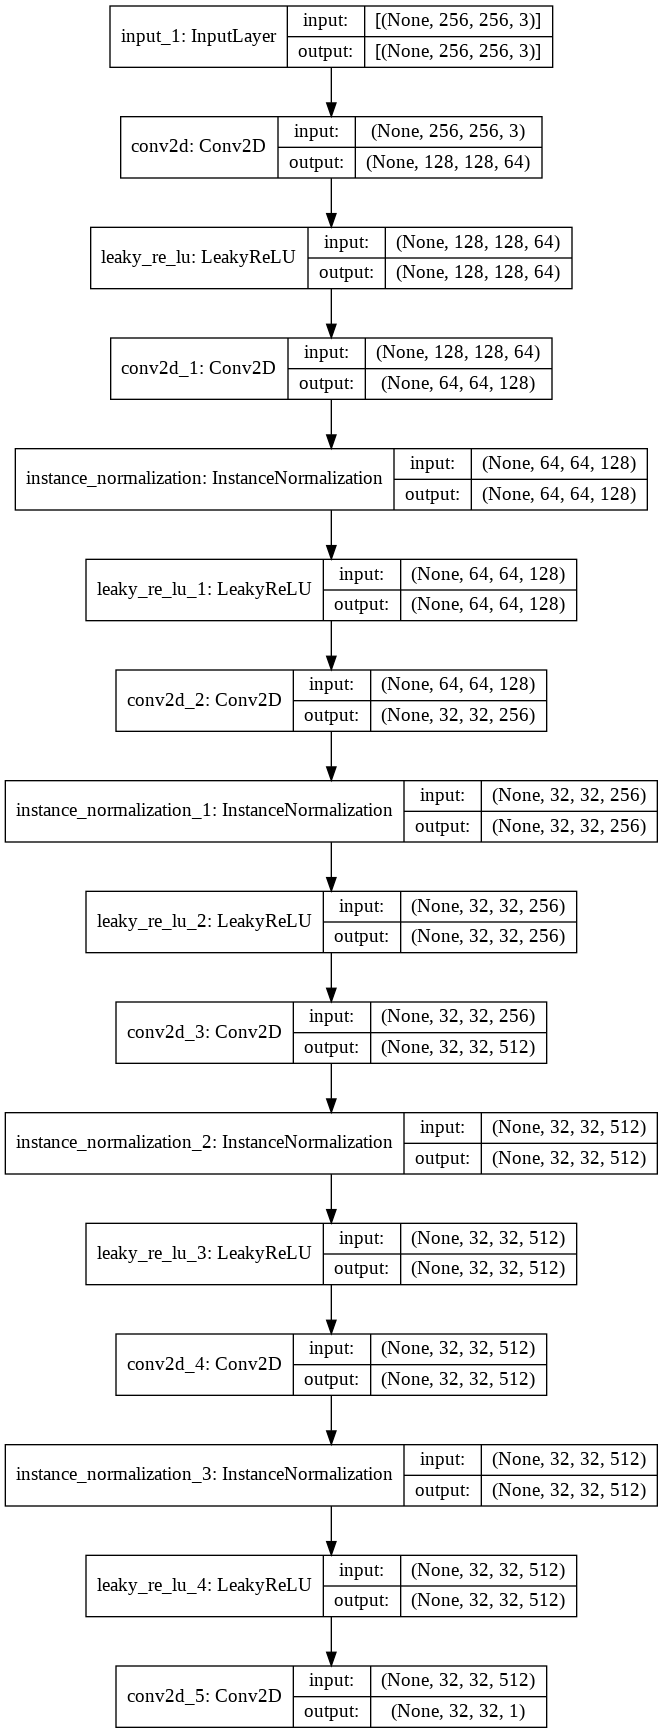

In [5]:
#Step 1: Defining a Patchgan discriminator model
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.utils import plot_model
import tensorflow as tf

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d) #Stride reduces shape of image
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

#############Note the final shape of the image patch=Patch size########################

In [6]:
#Step 2: Generator Model
# generator a resnet block
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization()(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization()(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [7]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=9):
	# weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=image_shape)
  # c7s1-64
  g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d128
  g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # d256
  g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # R256
  for _ in range(n_resnet):
    g = resnet_block(256, g)
  # u128
  g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # u64
  g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  g = Activation('relu')(g)
  # c7s1-3
  g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
  g=InstanceNormalization()(g)
  out_image = Activation('sigmoid')(g)
  # define model
  model = Model(in_image, out_image)
  return model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

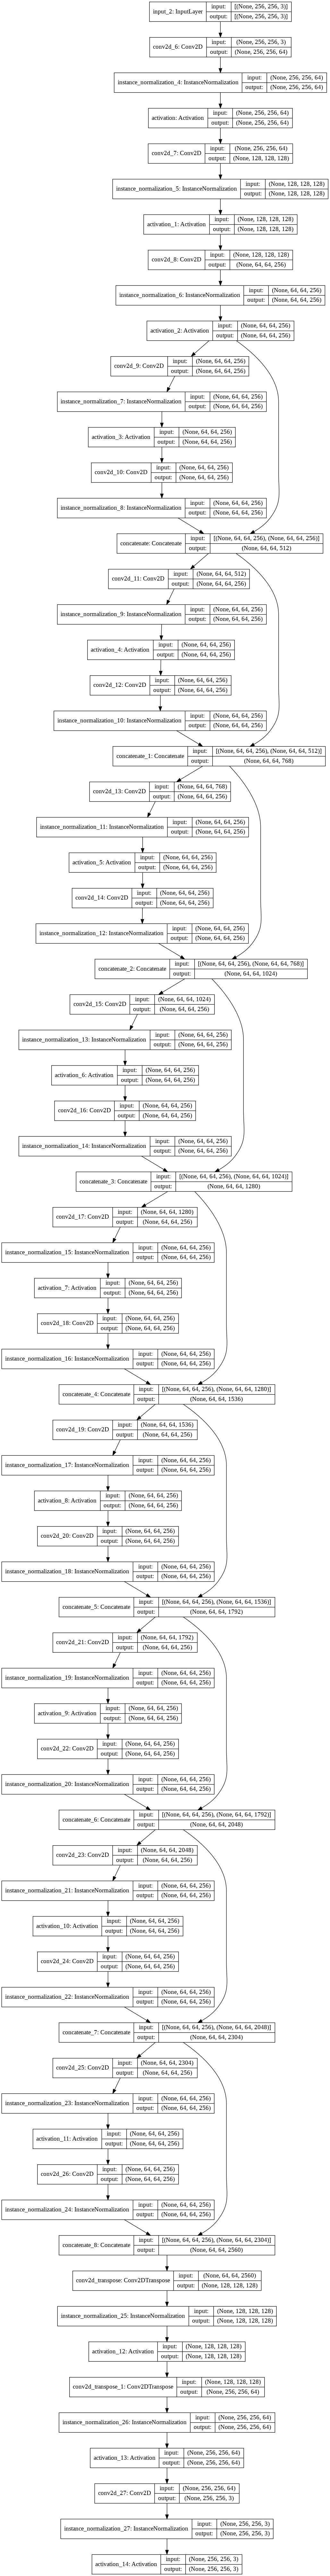

In [8]:
# create the model
model = define_generator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
# Step 3: Define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5) # beta is tuneable
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt) # loss functions AND weights can be tuneable
	return model
  ############Notice no cross enytropy loss used here######################################

In [10]:
#Step 4: All definitions together
# input shape
image_shape = (256,256,3)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

In [11]:
#Step 5: Helper functions to select real samples and generate fake samples

from random import randint
#write a function to generate 'n_samples' random integers in range (start,stop)
def randnums(start,stop,n_samples):
  ix=[]
  for i in range(n_samples):
    ix.append(randint(start,stop))
  ix=np.array(ix)
  return ix

In [12]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
# choose random instances
  ix = randnums(0, dataset.shape[0]-1, n_samples)
  # retrieve selected images
  #print(ix,np.shape(dataset))
  X = dataset[ix]
  # generate 'real' class labels (1)
  y = np.ones((n_samples, patch_shape, patch_shape, 1))
  return X, y


In [13]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
# update image pool for fake images
import random
def update_image_pool(pool, images, max_size=50):
  selected = list()
  for image in images:
    if len(pool) < max_size:
    # stock the pool
      pool.append(image)
      selected.append(image)
    elif random.random() < 0.5:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      ix = randint(0, len(pool)-1)
      print(ix,np.shape(pool))
      selected.append(pool[ix])
      pool[ix] = image
  return np.asarray(selected)


# All helper functions are now defined, now lets begin training!

Order of tasks:
* Update Generator-B (A->B)
* Update Discriminator-B
* Update Generator-A (B->A)
* Update Discriminator-A

In [15]:
# train function for the cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB):

  # define properties of the training run
  n_epochs, n_batch, = 10, 1 #Keep n_batch as 1 for per image training. n_epochs can be changed
  # determine the output square shape of the discriminator
  n_patch = d_model_A.output_shape[1] #Notice n_patch depends on the discriminator output image size. This parameter can be changed for improvement.
  
  # prepare image pool for fakes
  poolA, poolB = list(), list()
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  print(n_steps)
  for i in range(n_steps):
  # select a batch of real samples
    X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
    X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
    
    # generate a batch of fake samples
    X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
    X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
    # update fakes from pool
    X_fakeA = update_image_pool(poolA, X_fakeA)
    X_fakeB = update_image_pool(poolB, X_fakeB)
    # update generator B->A via adversarial and cycle loss
    g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
    # update discriminator for A -> [real/fake]
    dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
    dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    # update generator A->B via adversarial and cycle loss
    g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
    # update discriminator for B -> [real/fake]
    dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
    dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    # summarize performance
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
  return (g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA)

# **Task 2: Train the model from scratch** 
# Load the images DomainA-> Day, DomainB-> Night. 
You may use as many as 50 images to train the generator. More images will need more epochs and more train time. So limit training images to 30-50 images from each domain.
# Call the train function to train on the images


In [16]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
import cv2

In [17]:
def load_img(img_path):
  im_temp = PIL.Image.open(img_path)
  im_temp = np.array(im_temp)
  im_temp = np.true_divide(im_temp, 255.0)
  im1 = cv2.resize(im_temp, (256,256))
  return im1

In [20]:
# load a daytime images as trainA, nighttime images as train B (numpy lists)

trainA = np.array([load_img(os.path.join('day', i)) for 
                   i in os.listdir('day')[:]])
trainB = np.array([load_img(os.path.join('night', i)) for 
                   i in os.listdir('night')[:]])

# Next train the cycleGAN using the train function!

In [21]:
# train CycleGAN
#Call the function 
g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,trainA,trainB) #and save the returned model

1200
>1, dA[0.870,2.358] dB[1.279,1.277] g[11.448,9.966]
>2, dA[22.625,7.715] dB[10.300,1.848] g[14.250,53.691]
>3, dA[8.949,8.190] dB[3.927,1.859] g[12.110,8.569]
>4, dA[6.406,7.841] dB[2.780,9.150] g[15.501,10.285]
>5, dA[1.550,1.695] dB[2.623,2.327] g[7.957,7.006]
>6, dA[0.435,0.260] dB[5.892,5.142] g[9.667,8.333]
>7, dA[0.598,0.416] dB[1.318,5.538] g[8.364,6.901]
>8, dA[0.438,0.333] dB[0.940,1.625] g[7.652,6.524]
>9, dA[0.297,0.349] dB[0.736,0.642] g[9.248,8.882]
>10, dA[0.329,0.226] dB[0.324,0.455] g[6.253,5.549]
>11, dA[0.276,0.317] dB[0.417,0.533] g[8.456,7.008]
>12, dA[0.276,0.201] dB[0.414,0.408] g[8.957,7.155]
>13, dA[0.324,0.182] dB[0.387,0.339] g[5.451,5.359]
>14, dA[0.243,0.241] dB[0.288,0.250] g[8.948,8.471]
>15, dA[0.176,0.199] dB[0.414,0.288] g[8.517,7.663]
>16, dA[0.246,0.177] dB[0.258,0.352] g[6.667,6.128]
>17, dA[0.182,0.160] dB[0.368,0.210] g[8.019,6.953]
>18, dA[0.199,0.177] dB[0.219,0.284] g[6.144,5.503]
>19, dA[0.217,0.139] dB[0.287,0.160] g[8.321,6.980]
>20, dA[

In [23]:
# Save models
if not os.path.exists('../models'):
  os.makedirs('../models')

g_model_AtoB.save('../models'/g_modelAtoB')
g_model_BtoA.save('../models'/g_modelBtoA')
c_model_AtoB.save('../models'/c_modelAtoB')
c_model_BtoA.save('../models'/c_modelBtoA')


INFO:tensorflow:Assets written to: saved_model/g_modelAtoB/assets
INFO:tensorflow:Assets written to: saved_model/g_modelBtoA/assets
INFO:tensorflow:Assets written to: saved_model/c_modelAtoB/assets
INFO:tensorflow:Assets written to: saved_model/c_modelBtoA/assets


In [ ]:
# # load models
# cust = {'InstanceNormalization': InstanceNormalization}
# g_modelAtoB = load_model('../models'/g_modelAtoB.h5', cust)
# g_modelBtoA = load_model('../models'/g_modelBtoA.h5', cust)
# c_modelAtoB = load_model('../models'/c_modelAtoB.h5', cust)
# c_modelAtoB = load_model('../models'/c_modelBtoA.h5', cust)

# **Task 3**: Write a test function to generate fake images for the test set
### Create Day->Night, Night->Day. versions separately
### Visualize some images. What parameters would you change to improve?
Hint: Use the format of the train function to create the test function.

In [24]:
#Define a test function to generate day to night images
import matplotlib.pyplot as plt
def test(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB):

  X_realA=generate_real_samples(trainA, 1, 16)[0]
  X_realB=generate_real_samples(trainB, 1, 16)[0]
  X_fakeB=generate_fake_samples(g_model_AtoB, X_realA, 16)[0]
  X_fakeA=generate_fake_samples(g_model_BtoA, X_realB, 16)[0]
  
    ########First Day to night transformation
  print('Original Day Image is=\n')
  plt.imshow(np.squeeze(X_realA))
  plt.show()
  print('Original Night image is=\n')
  plt.imshow(np.squeeze(X_realB))
  plt.show()
  #############Next Night to Day transformation
  print('Fake Day Image is=\n')
  plt.imshow(np.squeeze(X_fakeA))
  plt.show()
  print('Fake Night image is=\n')
  plt.imshow(np.squeeze(X_fakeB))
  plt.show()


Original Day Image is=



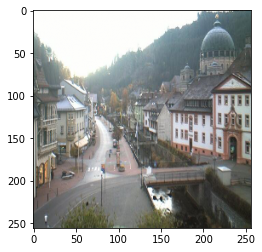

Original Night image is=



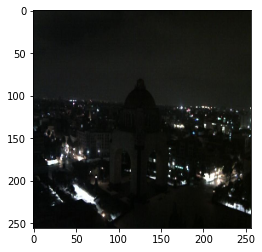

Fake Day Image is=



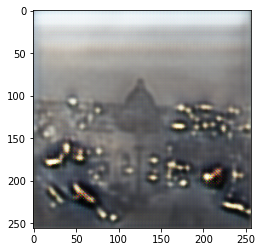

Fake Night image is=



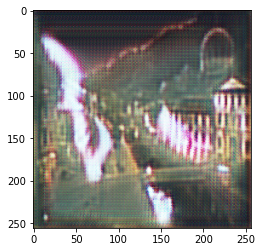

In [25]:
##Call the test function here test(.....)

test(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB)

 # Notice a Banding around edges for the nighttime images. What paremeter would you change to reduce this banding?

# **Task 4**: Write a function to generate a full cycle Day->night->Day
[Hint]: Use the template in the train function to start with Day image and plot the cyclic day image generated.

# Write a function to quantify the error and similarity between the cycle generated image and original image (Day vs Generated Day)
[Hint]: Find mse and structural similarity between real and fake images to gauge the quality of cycleGAN.



In [26]:
#Function to compute similarity in Cycle images
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error

def similarity_real_fake(real, fake):
  ssim = structural_similarity(real, fake, multichannel=True, gaussian_weights=True, sigma=1.5)
  mse = mean_squared_error(real, fake)
  # return mse, ssim
  print(f'mse={mse}, ssim={ssim}')


In [27]:
def test_Cycle(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA,trainB):

  # all the similarity_real_fake function above and print it under each real->Generated image pair
  n_epochs, n_batch = 1, 1
  n_patch = 32
  n_steps = 15

  for i in range(n_steps):
    X_realA = generate_real_samples(trainA, n_batch, n_patch)[0]
    X_realB = generate_real_samples(trainB, n_batch, n_patch)[0]

    X_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)[0]
    X_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)[0]

    X_fakeAA = generate_fake_samples(g_model_BtoA, X_fakeB, n_patch)[0]
    X_fakeBB = generate_fake_samples(g_model_AtoB, X_fakeA, n_patch)[0]

    realA = np.squeeze(X_realA)
    fakeA = np.squeeze(X_fakeAA)
    realB = np.squeeze(X_realB)
    fakeB = np.squeeze(X_fakeBB)

    print('Original Day Image is=\n')
    plt.imshow(realA)
    plt.show()
    print('Fake Day Image is=\n')
    plt.imshow(fakeA)
    plt.show()
    similarity_real_fake(realA, fakeA)

    print('Original Night Image is=\n')
    plt.imshow(realB)
    plt.show()
    print('Fake Night Image is=\n')
    plt.imshow(fakeB)
    plt.show()
    similarity_real_fake(realB, fakeB)


Original Day Image is=



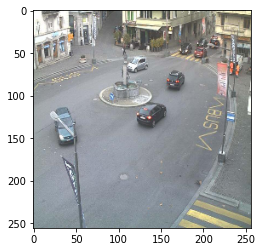

Fake Day Image is=



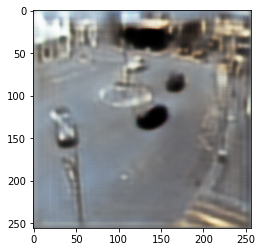

/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


mse=0.017153236427487895, ssim=0.7050592514994817
Original Night Image is=



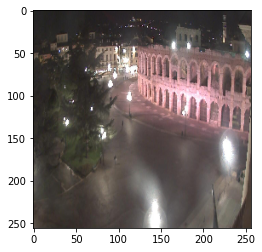

Fake Night Image is=



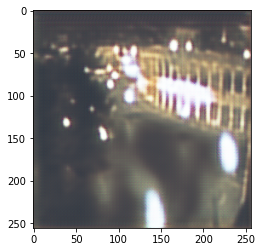

mse=0.011177348595331045, ssim=0.7833677941191911
Original Day Image is=



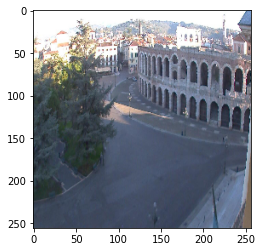

Fake Day Image is=



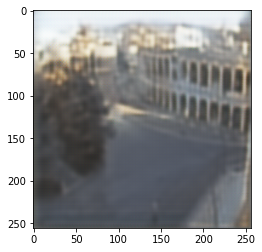

mse=0.007688501139752293, ssim=0.7486686442700378
Original Night Image is=



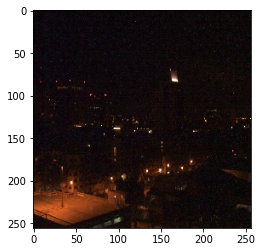

Fake Night Image is=



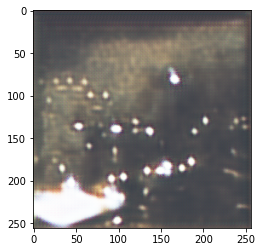

mse=0.13668350513157343, ssim=0.23151043801179708
Original Day Image is=



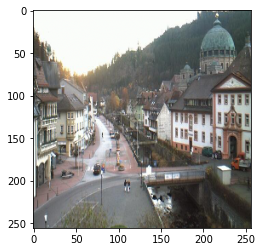

Fake Day Image is=



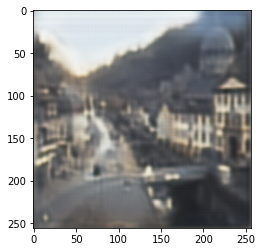

mse=0.011921189472304047, ssim=0.7135923396550016
Original Night Image is=



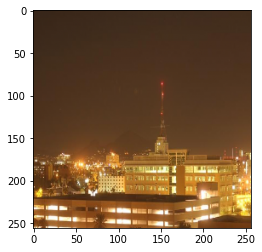

Fake Night Image is=



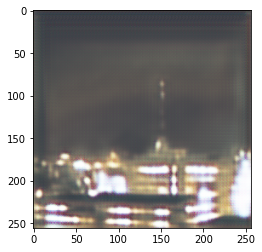

mse=0.032222524427518745, ssim=0.7296628755463863
Original Day Image is=



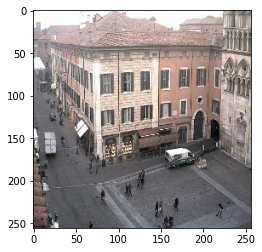

Fake Day Image is=



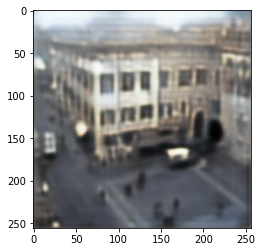

mse=0.013919821737225174, ssim=0.5679020656918329
Original Night Image is=



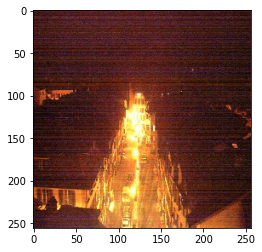

Fake Night Image is=



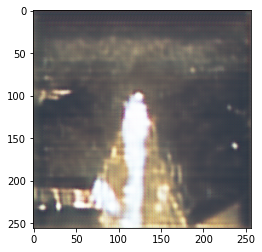

mse=0.04883469340529716, ssim=0.4566146024120236
Original Day Image is=



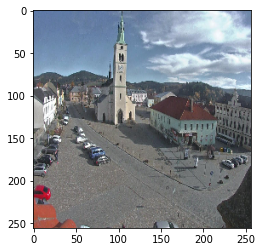

Fake Day Image is=



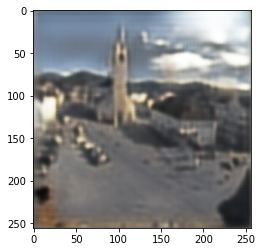

mse=0.009281808939618759, ssim=0.6851177852464369
Original Night Image is=



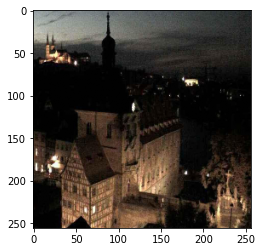

Fake Night Image is=



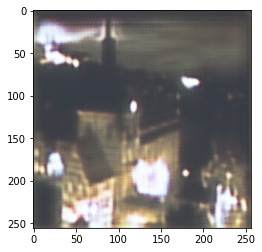

mse=0.07628732082831606, ssim=0.3715219771620765
Original Day Image is=



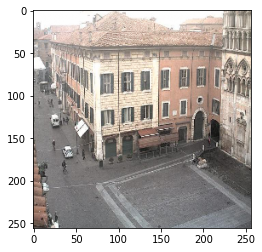

Fake Day Image is=



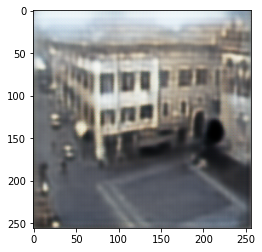

mse=0.021232097170009016, ssim=0.567532245647549
Original Night Image is=



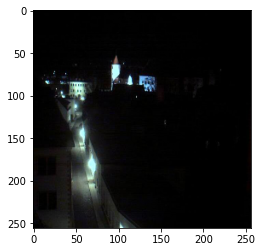

Fake Night Image is=



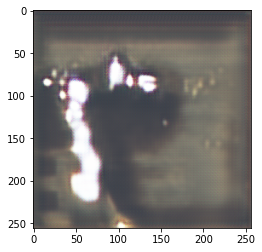

mse=0.14319510827625898, ssim=0.10482286534349657
Original Day Image is=



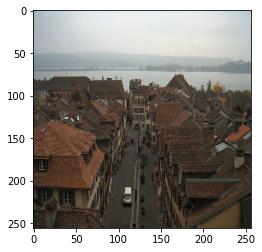

Fake Day Image is=



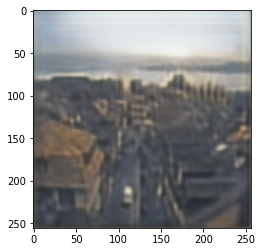

mse=0.012326103846609093, ssim=0.7090462052465915
Original Night Image is=



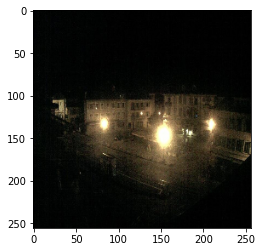

Fake Night Image is=



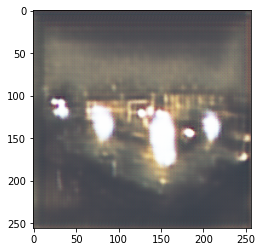

mse=0.11881324553586385, ssim=0.18713672249273192
Original Day Image is=



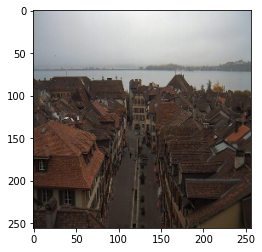

Fake Day Image is=



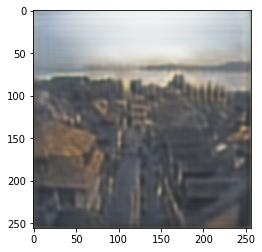

mse=0.01659039433145643, ssim=0.7007136768610279
Original Night Image is=



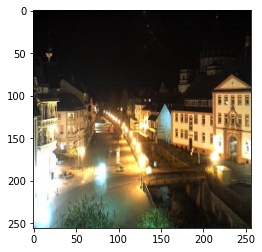

Fake Night Image is=



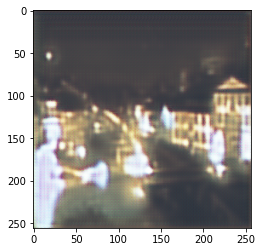

mse=0.03344849665039711, ssim=0.5039807237027741
Original Day Image is=



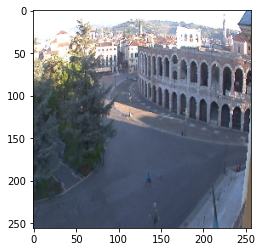

Fake Day Image is=



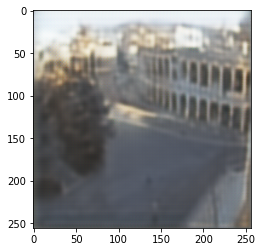

mse=0.007854338270807865, ssim=0.7427829914193825
Original Night Image is=



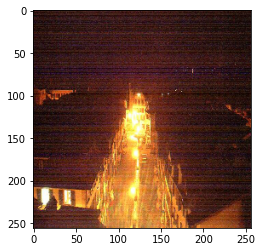

Fake Night Image is=



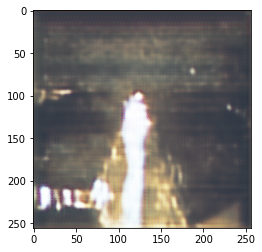

mse=0.052415013977441964, ssim=0.44100742149351824
Original Day Image is=



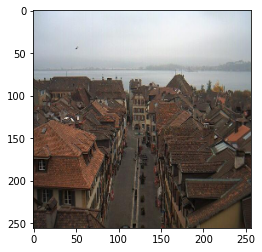

Fake Day Image is=



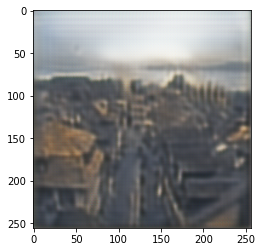

mse=0.010550162437399068, ssim=0.7054233272168151
Original Night Image is=



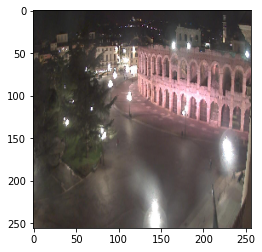

Fake Night Image is=



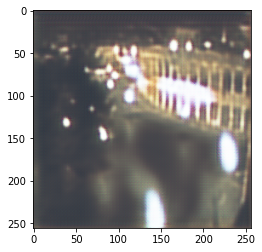

mse=0.011587625055365593, ssim=0.7820542177627404
Original Day Image is=



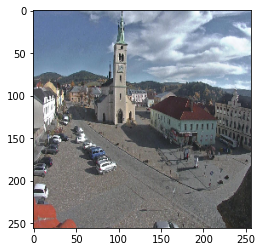

Fake Day Image is=



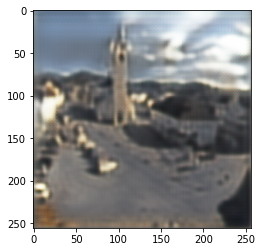

mse=0.010001724721482171, ssim=0.6783406437993279
Original Night Image is=



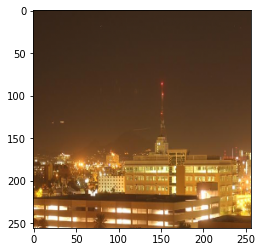

Fake Night Image is=



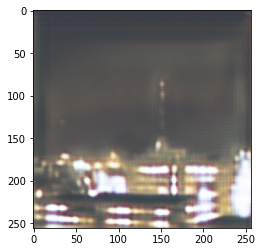

mse=0.032437842705764164, ssim=0.7267524657836372
Original Day Image is=



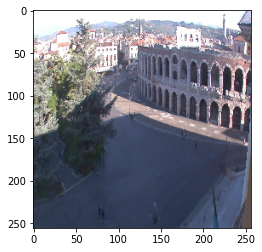

Fake Day Image is=



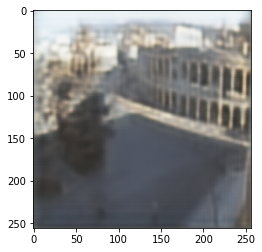

mse=0.010770852089169641, ssim=0.7018546051628816
Original Night Image is=



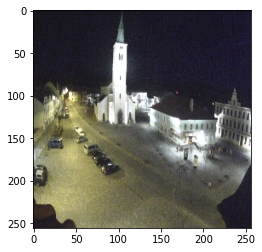

Fake Night Image is=



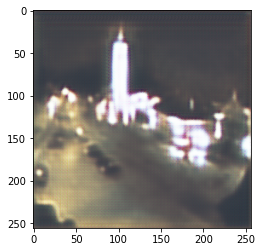

mse=0.01785632953104631, ssim=0.6744943987501429
Original Day Image is=



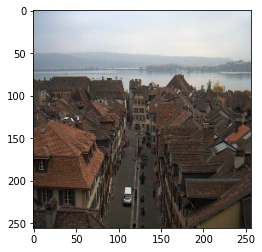

Fake Day Image is=



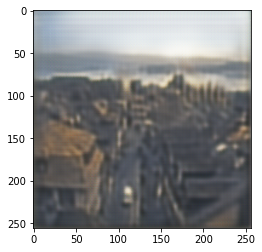

mse=0.01266412537602928, ssim=0.6940567963232191
Original Night Image is=



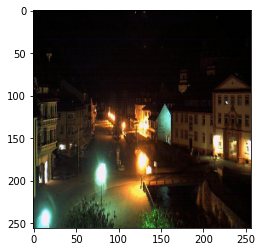

Fake Night Image is=



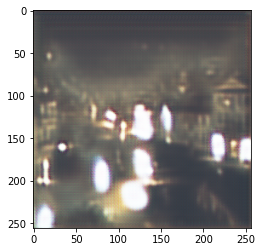

mse=0.08728943885120777, ssim=0.311974736350243
Original Day Image is=



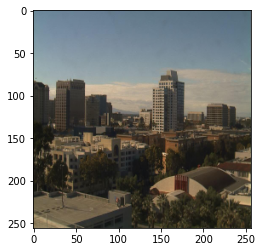

Fake Day Image is=



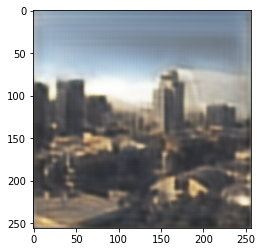

mse=0.019007519607731293, ssim=0.7565979529630568
Original Night Image is=



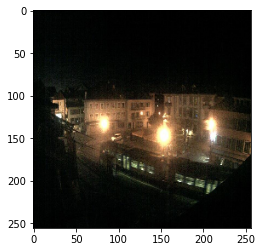

Fake Night Image is=



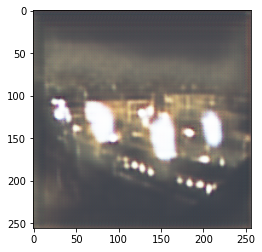

mse=0.10096615254528761, ssim=0.2301150039880019
Original Day Image is=



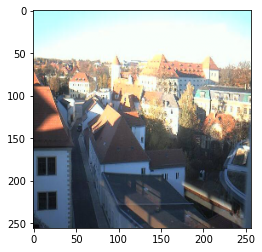

Fake Day Image is=



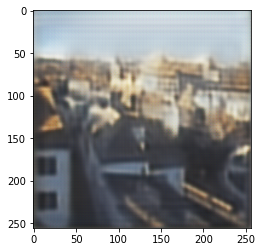

mse=0.017887163752567797, ssim=0.7420194478077643
Original Night Image is=



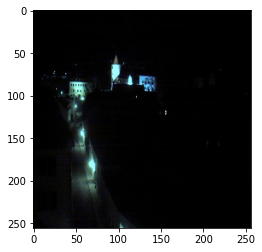

Fake Night Image is=



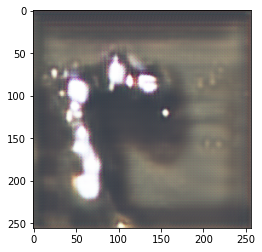

mse=0.16026143556488825, ssim=0.05735295706503041


In [28]:
# Call the function test_Cycle(....)
test_Cycle(g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB)

Right now, our `-> Day` performance appears to be better than `-> Night`. I've already improved that somewhat by changing the `patch_size` from 128 to 32. That helped with the banding around the edges, though that's obviously still present.

One thing that might help: Tuning of the composite model losses and their weights. There's a lot of exploring to be done here, from experimenting with `mse` vs `mae` on forward and backward loss to simply changing the weights of these losses (by factors of 5).